In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline


In [59]:
import matplotlib
%matplotlib inline 

matplotlib.rc('font', family='AppleGothic')

plt.rcParams["figure.figsize"] = (20,3)

In [2]:
class evaluation:
    def __init__(self, true_s):
        self.true_df = pd.DataFrame(true_s)
        self.true_df.columns = ['swell']
        self.true_df['swell(t+1)'] = self.true_df['swell'].shift(-1)
        self.true_df['swell(t+2)'] = self.true_df['swell'].shift(-2)
        self.true_df['swell(t-1)'] = self.true_df['swell'].shift(1)
        self.true_df['swell(t-2)'] = self.true_df['swell'].shift(2)
    
        self.swell_columns = ['swell(t+1)','swell(t+2)','swell(t-1)','swell(t-2)']
    
    def _eval_one(self, pred):
        true = self.true_df.loc[pred.name]
        swell = true['swell'] 
        p_swell = pred['pred']

        if swell == 0 and p_swell == 0:
            return 1

        if swell == 1 and p_swell == 1:
            return 2

        if swell == 0 and p_swell == 1:
            if (true[self.swell_columns].values == 1).any():
                return 0
            else:
                return -1

        if swell == 1 and p_swell == 0:
            if (pred[self.swell_columns].values == 1).any():
                return 0
            else: 
                return -2
    
    def evaluate(self, pred):
        pred_df = pd.DataFrame(pred)
        pred_df.columns = ['pred']
        pred_df['swell(t+1)'] = pred_df['pred'].shift(-1)
        pred_df['swell(t+2)'] = pred_df['pred'].shift(-2)
        pred_df['swell(t-1)'] = pred_df['pred'].shift(1)
        pred_df['swell(t-2)'] = pred_df['pred'].shift(2)

        result = []
        for index in pred_df.index:
            result.append(self._eval_one(pred_df.loc[index]))
        
        #print(result)
        print(pd.Series(result).value_counts())
        
        return np.sum(result)

In [3]:
df = pd.read_csv('./all_merged_info_data.tsv',sep='\t',index_col='Unnamed: 0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 77 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_일시                 33979 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_일시                 19639 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 no

In [4]:
df['swell'].value_counts()

0.0    31800
1.0     2592
Name: swell, dtype: int64

In [5]:
df['swell'] = df['swell'] + df['weather_deterioration']

In [6]:
df['swell'].value_counts()

0.0    26863
1.0     4937
2.0     2592
Name: swell, dtype: int64

In [7]:
def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:8])
    day = datetime(y, m, d)
    return day.weekday()

In [8]:
# 음력 추가
from korean_lunar_calendar import KoreanLunarCalendar
from datetime import datetime

def add_lunar_date(df):
    calendar = KoreanLunarCalendar()
    
    lunar_y = []
    lunar_m = []
    lunar_d = []
    for y, m, d in zip (df['year'], df['month'], df['day']):
        calendar.setSolarDate(y, m, d)
        lunar_date = calendar.LunarIsoFormat()
        lunar_y.append(int(lunar_date[:4]))
        lunar_m.append(int(lunar_date[5:7]))
        lunar_d.append(int(lunar_date[8:10]))
        
    df['lunar_year'], df['lunar_month'], df['lunar_day'] = lunar_y, lunar_m, lunar_d


In [9]:
df['month'] = df['hour'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['hour'].apply(lambda x:int(str(x)[6:8]))
df['day_hour'] = df['hour'].apply(lambda x:int((str(x)[8:])))
df['week'] = df['hour'].apply(date2week)
df['weekday'] = df['week'] + 1 
df['year'] = df['hour'].apply(lambda x:int(str(x)[:4]))

In [10]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    df.drop(['month', 'lunar_month'], axis=1, inplace=True)
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    df.drop(['day', 'lunar_day'], axis=1, inplace=True)
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]

In [11]:
%%time
add_lunar_date(df)

In [12]:
year_norm(df)
month_norm(df)
day_norm(df)
weekday_norm(df)

In [13]:
s = (df[df['swell'].isnull()]['hour']//100).value_counts()
s

20170315    17
20171211    17
20161130    17
20170331    17
20141023    17
20161020    17
20140518    17
20170212    17
20150718    17
20140706    17
20150627    17
20160830    17
20171023    17
20171012    17
20141221    17
20170916    17
20160122    17
20150404    17
20150113    17
20140925    17
20170603    17
20161226    17
20151213    17
20160304    17
20151113    17
20160831     7
20170604     7
20171024     7
20140926     7
20171013     7
20150114     7
20141222     7
20151214     7
20150405     7
20150628     7
20140707     7
20150719     7
20170401     7
20171212     7
20170917     7
20151114     7
20170213     7
20140519     7
20160305     7
20161021     7
20170316     7
20161227     7
20161201     7
20160123     7
20141024     7
Name: hour, dtype: int64

In [14]:
s[s > 10].index.tolist()[0]

20170315

In [15]:
def get_prev_date(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return (today - timedelta(1)).strftime('%Y%m%d%H')

In [16]:
def get_today_from_07(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return today.strftime('%Y%m%d%H')

In [17]:
get_prev_date('20170101')

'2016123100'

In [18]:
get_today_from_07('20170101')

'2017010100'

In [19]:
s[s>10].index.astype(str).sort_values()

Index(['20140518', '20140706', '20140925', '20141023', '20141221', '20150113',
       '20150404', '20150627', '20150718', '20151113', '20151213', '20160122',
       '20160304', '20160830', '20161020', '20161130', '20161226', '20170212',
       '20170315', '20170331', '20170603', '20170916', '20171012', '20171023',
       '20171211'],
      dtype='object')

In [20]:
test_date_hour = []
for d in s[s>10].index.astype(str):
    #day = get_prev_date(d)
    day = get_prev_date(d)
    tomorrow_day = int(day) +  100 
    
    if tomorrow_day == 2016113100:
        tomorrow_day = 2016120100

    if tomorrow_day == 2017033200:
        tomorrow_day = 2017040100
        
    print(day, tomorrow_day)
    for hour in range(7,24):
        test_date_hour.append((int(day) + hour))
            
    for hour in range(0,7):
        test_date_hour.append((tomorrow_day + hour))

test_date_hour = list(map(str,test_date_hour))
len(test_date_hour)

2017031400 2017031500
2017121000 2017121100
2016112900 2016113000
2017033000 2017033100
2014102200 2014102300
2016101900 2016102000
2014051700 2014051800
2017021100 2017021200
2015071700 2015071800
2014070500 2014070600
2015062600 2015062700
2016082900 2016083000
2017102200 2017102300
2017101100 2017101200
2014122000 2014122100
2017091500 2017091600
2016012100 2016012200
2015040300 2015040400
2015011200 2015011300
2014092400 2014092500
2017060200 2017060300
2016122500 2016122600
2015121200 2015121300
2016030300 2016030400
2015111200 2015111300


600

In [21]:
df['swell(t+1)'] = df['swell'].shift(-1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34992 entries, 0 to 34991
Data columns (total 93 columns):
hour                     34992 non-null int64
climate                  34992 non-null object
weather_deterioration    34992 non-null int64
swell                    34392 non-null float64
22453_일시                 33979 non-null float64
22453_수온(°C)             33082 non-null float64
22453_최대파고(m)            33632 non-null float64
22453_유의파고(m)            33632 non-null float64
22453_평균파고(m)            33632 non-null float64
22453_파주기(sec)           33634 non-null float64
22490_일시                 19639 non-null float64
22490_수온(°C)             19464 non-null float64
22490_최대파고(m)            19224 non-null float64
22490_유의파고(m)            19224 non-null float64
22490_평균파고(m)            19224 non-null float64
22490_파주기(sec)           19562 non-null float64
21229_GUST풍속 1(m/s)      8637 non-null float64
21229_GUST풍속(m/s)        26091 non-null float64
21229_기온(°C)             33915 no

In [22]:
df.columns

Index(['hour', 'climate', 'weather_deterioration', 'swell', '22453_일시',
       '22453_수온(°C)', '22453_최대파고(m)', '22453_유의파고(m)', '22453_평균파고(m)',
       '22453_파주기(sec)', '22490_일시', '22490_수온(°C)', '22490_최대파고(m)',
       '22490_유의파고(m)', '22490_평균파고(m)', '22490_파주기(sec)',
       '21229_GUST풍속 1(m/s)', '21229_GUST풍속(m/s)', '21229_기온(°C)',
       '21229_수온(°C)', '21229_습도(%)', '21229_유의파고(m)', '21229_일시',
       '21229_최대파고(m)', '21229_파주기(sec)', '21229_파향(deg)', '21229_평균파고(m)',
       '21229_풍속(m/s)', '21229_풍속1(m/s)', '21229_풍향(deg)', '21229_풍향1(deg)',
       '21229_현지기압(hPa)', '22105_GUST풍속 1(m/s)', '22105_GUST풍속(m/s)',
       '22105_기온(°C)', '22105_수온(°C)', '22105_습도(%)', '22105_유의파고(m)',
       '22105_일시', '22105_최대파고(m)', '22105_파주기(sec)', '22105_파향(deg)',
       '22105_평균파고(m)', '22105_풍속(m/s)', '22105_풍속1(m/s)', '22105_풍향(deg)',
       '22105_풍향1(deg)', '22105_현지기압(hPa)', '22106_GUST풍속 1(m/s)',
       '22106_GUST풍속(m/s)', '22106_기온(°C)', '22106_수온(°C)', '22106_습도(%)',
       '

In [23]:
def output_change(x):
    if x == 2:
        return 1
    else:
        return 0

In [24]:
df['hour'] = df['hour'].astype(str)
df['index'] = df.index
df.set_index('hour',inplace=True,)

### 테스트 데이터 하나당 feature selection을 수행

In [146]:
sorted(test_date_hour)

['2014051707',
 '2014051708',
 '2014051709',
 '2014051710',
 '2014051711',
 '2014051712',
 '2014051713',
 '2014051714',
 '2014051715',
 '2014051716',
 '2014051717',
 '2014051718',
 '2014051719',
 '2014051720',
 '2014051721',
 '2014051722',
 '2014051723',
 '2014051800',
 '2014051801',
 '2014051802',
 '2014051803',
 '2014051804',
 '2014051805',
 '2014051806',
 '2014070507',
 '2014070508',
 '2014070509',
 '2014070510',
 '2014070511',
 '2014070512',
 '2014070513',
 '2014070514',
 '2014070515',
 '2014070516',
 '2014070517',
 '2014070518',
 '2014070519',
 '2014070520',
 '2014070521',
 '2014070522',
 '2014070523',
 '2014070600',
 '2014070601',
 '2014070602',
 '2014070603',
 '2014070604',
 '2014070605',
 '2014070606',
 '2014092407',
 '2014092408',
 '2014092409',
 '2014092410',
 '2014092411',
 '2014092412',
 '2014092413',
 '2014092414',
 '2014092415',
 '2014092416',
 '2014092417',
 '2014092418',
 '2014092419',
 '2014092420',
 '2014092421',
 '2014092422',
 '2014092423',
 '2014092500',
 '20140925

### col 중 20% 이상의 미싱벨류가 있는 경우 삭제

In [26]:
df.columns

Index(['climate', 'weather_deterioration', 'swell', '22453_일시', '22453_수온(°C)',
       '22453_최대파고(m)', '22453_유의파고(m)', '22453_평균파고(m)', '22453_파주기(sec)',
       '22490_일시', '22490_수온(°C)', '22490_최대파고(m)', '22490_유의파고(m)',
       '22490_평균파고(m)', '22490_파주기(sec)', '21229_GUST풍속 1(m/s)',
       '21229_GUST풍속(m/s)', '21229_기온(°C)', '21229_수온(°C)', '21229_습도(%)',
       '21229_유의파고(m)', '21229_일시', '21229_최대파고(m)', '21229_파주기(sec)',
       '21229_파향(deg)', '21229_평균파고(m)', '21229_풍속(m/s)', '21229_풍속1(m/s)',
       '21229_풍향(deg)', '21229_풍향1(deg)', '21229_현지기압(hPa)',
       '22105_GUST풍속 1(m/s)', '22105_GUST풍속(m/s)', '22105_기온(°C)',
       '22105_수온(°C)', '22105_습도(%)', '22105_유의파고(m)', '22105_일시',
       '22105_최대파고(m)', '22105_파주기(sec)', '22105_파향(deg)', '22105_평균파고(m)',
       '22105_풍속(m/s)', '22105_풍속1(m/s)', '22105_풍향(deg)', '22105_풍향1(deg)',
       '22105_현지기압(hPa)', '22106_GUST풍속 1(m/s)', '22106_GUST풍속(m/s)',
       '22106_기온(°C)', '22106_수온(°C)', '22106_습도(%)', '22106_유의파고(m)',

In [168]:
one_test_df = df.loc[:'2014070510']
one_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4372 entries, 2014010407 to 2014070510
Data columns (total 93 columns):
climate                  4372 non-null object
weather_deterioration    4372 non-null int64
swell                    4348 non-null float64
22453_일시                 4266 non-null float64
22453_수온(°C)             4266 non-null float64
22453_최대파고(m)            4265 non-null float64
22453_유의파고(m)            4265 non-null float64
22453_평균파고(m)            4265 non-null float64
22453_파주기(sec)           4266 non-null float64
22490_일시                 0 non-null float64
22490_수온(°C)             0 non-null float64
22490_최대파고(m)            0 non-null float64
22490_유의파고(m)            0 non-null float64
22490_평균파고(m)            0 non-null float64
22490_파주기(sec)           0 non-null float64
21229_GUST풍속 1(m/s)      4357 non-null float64
21229_GUST풍속(m/s)        0 non-null float64
21229_기온(°C)             4358 non-null float64
21229_수온(°C)             4318 non-null float64
21229_습도(%)   

In [169]:
all_size = len(one_test_df)
all_size

4372

In [170]:
col_df = pd.DataFrame(one_test_df.isnull().sum() / all_size < 0.2)
possible_cols = col_df[col_df[0]==True].index.tolist()
possible_cols

['climate',
 'weather_deterioration',
 'swell',
 '22453_일시',
 '22453_수온(°C)',
 '22453_최대파고(m)',
 '22453_유의파고(m)',
 '22453_평균파고(m)',
 '22453_파주기(sec)',
 '21229_GUST풍속 1(m/s)',
 '21229_기온(°C)',
 '21229_수온(°C)',
 '21229_습도(%)',
 '21229_유의파고(m)',
 '21229_일시',
 '21229_최대파고(m)',
 '21229_파주기(sec)',
 '21229_파향(deg)',
 '21229_평균파고(m)',
 '21229_풍속1(m/s)',
 '21229_풍향1(deg)',
 '21229_현지기압(hPa)',
 '22105_GUST풍속 1(m/s)',
 '22105_기온(°C)',
 '22105_수온(°C)',
 '22105_습도(%)',
 '22105_유의파고(m)',
 '22105_일시',
 '22105_최대파고(m)',
 '22105_파주기(sec)',
 '22105_파향(deg)',
 '22105_평균파고(m)',
 '22105_풍속1(m/s)',
 '22105_풍향1(deg)',
 '22105_현지기압(hPa)',
 '22106_GUST풍속 1(m/s)',
 '22106_기온(°C)',
 '22106_수온(°C)',
 '22106_습도(%)',
 '22106_유의파고(m)',
 '22106_일시',
 '22106_최대파고(m)',
 '22106_파주기(sec)',
 '22106_파향(deg)',
 '22106_평균파고(m)',
 '22106_풍속1(m/s)',
 '22106_풍향1(deg)',
 '22106_현지기압(hPa)',
 'day_hour',
 'week',
 'weekday',
 'year',
 'lunar_year',
 'month_sin',
 'month_cos',
 'lunar_month_sin',
 'lunar_month_cos',
 'day_sin',
 'd

In [171]:
possible_df = one_test_df[possible_cols]
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4372 entries, 2014010407 to 2014070510
Data columns (total 65 columns):
climate                  4372 non-null object
weather_deterioration    4372 non-null int64
swell                    4348 non-null float64
22453_일시                 4266 non-null float64
22453_수온(°C)             4266 non-null float64
22453_최대파고(m)            4265 non-null float64
22453_유의파고(m)            4265 non-null float64
22453_평균파고(m)            4265 non-null float64
22453_파주기(sec)           4266 non-null float64
21229_GUST풍속 1(m/s)      4357 non-null float64
21229_기온(°C)             4358 non-null float64
21229_수온(°C)             4318 non-null float64
21229_습도(%)              4358 non-null float64
21229_유의파고(m)            4356 non-null float64
21229_일시                 4359 non-null float64
21229_최대파고(m)            4356 non-null float64
21229_파주기(sec)           4357 non-null float64
21229_파향(deg)            4358 non-null float64
21229_평균파고(m)            4356 non-null f

In [172]:
possible_df.fillna(method='ffill',inplace=True)
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4372 entries, 2014010407 to 2014070510
Data columns (total 65 columns):
climate                  4372 non-null object
weather_deterioration    4372 non-null int64
swell                    4372 non-null float64
22453_일시                 4372 non-null float64
22453_수온(°C)             4372 non-null float64
22453_최대파고(m)            4372 non-null float64
22453_유의파고(m)            4372 non-null float64
22453_평균파고(m)            4372 non-null float64
22453_파주기(sec)           4372 non-null float64
21229_GUST풍속 1(m/s)      4372 non-null float64
21229_기온(°C)             4372 non-null float64
21229_수온(°C)             4372 non-null float64
21229_습도(%)              4372 non-null float64
21229_유의파고(m)            4372 non-null float64
21229_일시                 4372 non-null float64
21229_최대파고(m)            4372 non-null float64
21229_파주기(sec)           4372 non-null float64
21229_파향(deg)            4372 non-null float64
21229_평균파고(m)            4372 non-null f

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [173]:
#train_df, test_df = train_test_split(possible_df,test_size=0.2)
train_df, test_df = possible_df.iloc[:int(all_size*0.8)],possible_df.iloc[int(all_size*0.8):]

In [174]:
print(train_df.shape, test_df.shape)

(3497, 65) (875, 65)


In [175]:
train_X = train_df.drop(['swell(t+1)','swell','index','climate','weather_deterioration','week','weekday','day_hour'],axis=1)
train_y = train_df['swell(t+1)']

In [176]:
test_X = test_df.drop(['swell(t+1)','swell','index','climate','weather_deterioration','week','weekday','day_hour'],axis=1)
test_y = test_df['swell(t+1)']

### Random forest classifcation

In [177]:
model = RandomForestClassifier(n_estimators=150)
model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [178]:
model.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [179]:
pred = model.predict(test_X)

In [180]:
from sklearn.metrics import f1_score,accuracy_score

In [181]:
f1_score(pred,test_y,average='weighted')

0.82344964123761821

In [182]:
accuracy_score(pred,test_y)

0.7142857142857143

In [183]:
test_df['pred'] = pred

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [184]:
test_df[['swell(t+1)','pred']]

,swell(t+1),pred
hour,,
2014053000,0.0,0.0
2014053001,0.0,0.0
2014053002,0.0,0.0
2014053003,0.0,0.0
2014053004,0.0,0.0
2014053005,0.0,0.0
2014053006,0.0,0.0
2014053007,0.0,0.0
2014053008,0.0,0.0


In [185]:
test_df['swell(t+1)'].value_counts()

0.0    616
1.0    204
2.0     55
Name: swell(t+1), dtype: int64

In [186]:
class2 = test_df[test_df['swell(t+1)'] == 2][['swell(t+1)','pred']]
class2

,swell(t+1),pred
hour,,
2014061323,2.0,0.0
2014061400,2.0,0.0
2014061401,2.0,0.0
2014061402,2.0,2.0
2014061403,2.0,0.0
2014061404,2.0,0.0
2014061405,2.0,2.0
2014061406,2.0,0.0
2014061407,2.0,0.0


In [187]:
accuracy_score(class2['swell(t+1)'],class2['pred'].apply(lambda x : 2 if x == 1 else x))

0.036363636363636362

In [188]:
accuracy_score(class2['swell(t+1)'],class2['pred'])

0.036363636363636362

In [189]:
importances = model.feature_importances_
X = train_X

Feature ranking:
1. feature 35 (0.055755)
2. feature 2 (0.050596)
3. feature 3 (0.050078)
4. feature 4 (0.039830)
5. feature 17 (0.036248)
6. feature 30 (0.031003)
7. feature 43 (0.030787)
8. feature 36 (0.029581)
9. feature 5 (0.026118)
10. feature 41 (0.025195)
11. feature 38 (0.025146)
12. feature 22 (0.024333)
13. feature 34 (0.023112)
14. feature 31 (0.023039)
15. feature 7 (0.021795)
16. feature 21 (0.020070)
17. feature 44 (0.019954)
18. feature 33 (0.019876)
19. feature 8 (0.019782)
20. feature 20 (0.019768)
21. feature 37 (0.018180)
22. feature 32 (0.017869)
23. feature 1 (0.017390)
24. feature 13 (0.017012)
25. feature 14 (0.016226)
26. feature 11 (0.015773)
27. feature 51 (0.014763)
28. feature 42 (0.014641)
29. feature 24 (0.014616)
30. feature 0 (0.014547)
31. feature 53 (0.014123)
32. feature 26 (0.013772)
33. feature 9 (0.013741)
34. feature 54 (0.013701)
35. feature 18 (0.013274)
36. feature 39 (0.013187)
37. feature 23 (0.012656)
38. feature 29 (0.012386)
39. feature 5

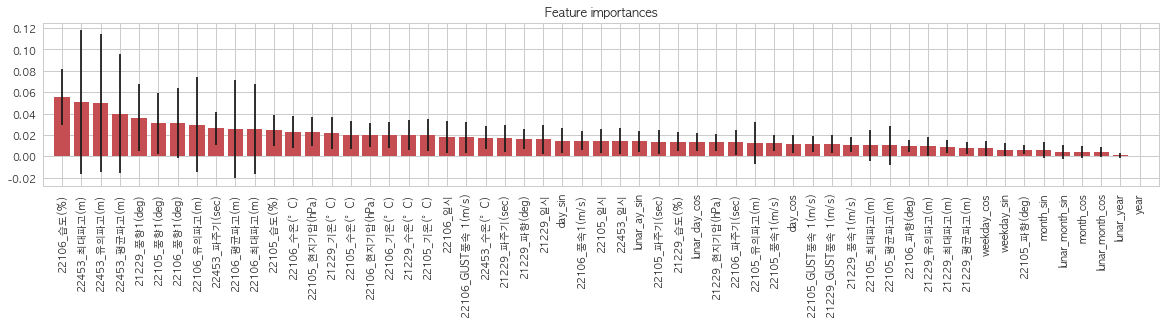

In [190]:
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

In [31]:
def result(x):
    if x >0.10:
        return 1
    
    return 0

In [32]:
pred_df['swell'] = pred_df[1].apply(lambda x: result(x))
pred_df

,0,1,swell
0,3,0.082941,0
1,1,0.082941,0
2,0,0.082941,0
3,2,0.082941,0
4,1,0.082941,0
5,1,0.082941,0
6,0,0.082941,0
7,0,0.082941,0
8,0,0.082941,0
9,1,0.082941,0


In [33]:
pred_df['swell'].value_counts()

0    421
1    179
Name: swell, dtype: int64

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanumgothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


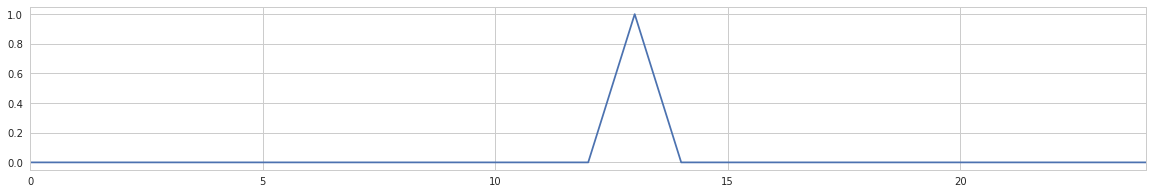

In [34]:
index = 0
pred_df.loc[index:index+24]['swell'].plot()

In [35]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
0        600 non-null int64
1        600 non-null float64
swell    600 non-null int64
dtypes: float64(1), int64(2)
memory usage: 14.1 KB


In [36]:
test['pred'] = pred_df['swell'].tolist()

In [37]:
index=24
test.iloc[index:index+24].T

hour,2017121007,2017121008,2017121009,2017121010,2017121011,2017121012,2017121013,2017121014,2017121015,2017121016,...,2017121021,2017121022,2017121023,2017121100,2017121101,2017121102,2017121103,2017121104,2017121105,2017121106
index,34464.0,34465.0,34466.0,34467.0,34468.0,34469.0,34470.0,34471.0,34472.0,34473.0,...,34478.0,34479.0,34480.0,34481.0,34482.0,34483.0,34484.0,34485.0,34486.0,34487.0
22105_파주기(sec),6.4,5.8,5.3,3.6,3.4,4.3,4.3,4.6,4.9,4.6,...,4.9,4.9,5.3,7.1,8.0,8.0,7.1,8.0,8.0,8.0
swell(t+1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pred,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
eval_metric = evaluation(df['swell(t+1)'].apply(output_change))

In [39]:
scores = []
for day in range(25):
    st = day*24
    print(st)
    scores.append(eval_metric.evaluate(test['pred'][st:st + 24]))

print(scores)

0
 1    23
-1     1
dtype: int64
24
1    24
dtype: int64
48
1    24
dtype: int64
72
1    24
dtype: int64
96
-2    12
 1    12
dtype: int64
120
1    24
dtype: int64
144
 2    18
 0     3
-1     3
dtype: int64
168
 2    11
 0     8
-2     5
dtype: int64
192
 2    12
 0     6
-2     5
 1     1
dtype: int64
216
-1    21
 1     3
dtype: int64
240
 1    20
-1     4
dtype: int64
264
2    22
0     2
dtype: int64
288
-1    15
 1     9
dtype: int64
312
1    24
dtype: int64
336
 1    23
-1     1
dtype: int64
360
1    24
dtype: int64
384
2    19
0     5
dtype: int64
408
 1    23
-1     1
dtype: int64
432
2    13
0     9
1     2
dtype: int64
456
1    24
dtype: int64
480
-1    14
 1    10
dtype: int64
504
1    11
2     8
0     5
dtype: int64
528
 0    10
 2     7
-2     6
 1     1
dtype: int64
552
1    24
dtype: int64
576
-2    21
 1     3
dtype: int64
[22, 24, 24, 24, -12, 24, 33, 12, 15, -18, 16, 44, -6, 24, 22, 24, 38, 22, 28, 24, -4, 27, 3, 24, -39]


In [40]:
np.sum(scores)

395